### How does a PyTorch Basic Workflow look like

- Data (prepare and load)
- Build Model
- Fitting the model to data
- Making predicitons and evaluation a model(inferencing)
- Improve through experimentation(optimizing)
- Saving and loading a model
- Putting it all together

In [ ]:
import torch
from torch import nn ## contains all the basic building blocks for pytorch neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.4.0+cu121'

### Data (Preparing and loading)

- Data can be almost anything
- Get all the type of data in numerical format

In [ ]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Train, val and test split

In [ ]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None) :

  """
    Plots training data, test data and compare
  """

  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions data")

  plt.legend(prop={"size":14})

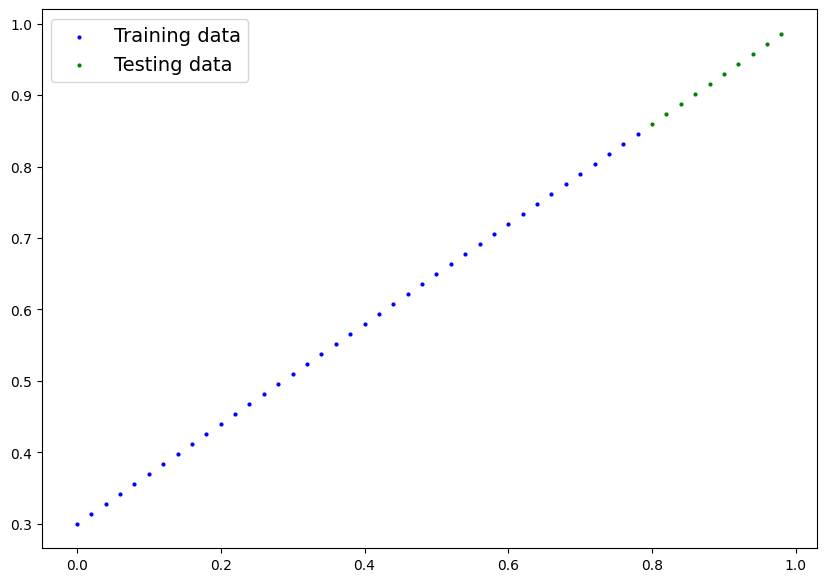

In [ ]:
plot_predictions()

### Building a model

In [ ]:
from torch import nn
# Linear regression

class LinearRegressionModel(nn.Module): # nn.Module subclass should be there if you are creating a PyTorch model
  def __init__(self):
    super().__init__() # to call init function of subclass

    # nn.Parameter is used to assign which tensors to be specified as learnable parameters
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, # can  this paramtere be updated by gradient descent
                                            dtype=torch.float32))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float32))

  # Forward method
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias



### Checking contents of our PyTorch model

In [ ]:
# Creating random seed

torch.manual_seed(10)

# Creating instance of the model(this is subclass of the model we created)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([-0.6014], requires_grad=True),
 Parameter containing:
 tensor([-1.0122], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([-0.6014])), ('bias', tensor([-1.0122]))])

### Make predictions using `torch.inference_mode()`

In [ ]:
# Making predictions

with torch.inference_mode(): # Inference mode turns off the gradient tracking
  y_pred = model_0(X_test)

y_pred

tensor([[-1.4933],
        [-1.5054],
        [-1.5174],
        [-1.5294],
        [-1.5414],
        [-1.5535],
        [-1.5655],
        [-1.5775],
        [-1.5895],
        [-1.6016]])

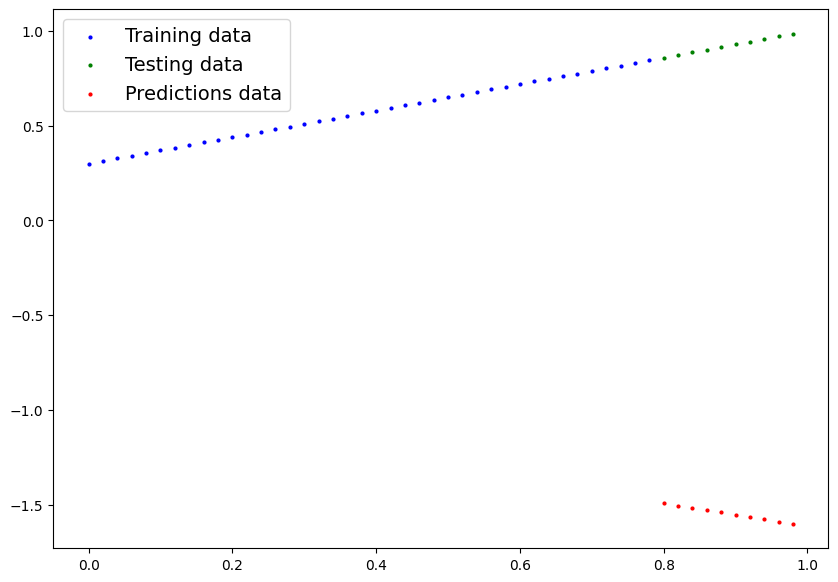

In [ ]:
plot_predictions(predictions=y_pred)

### Training the model

Things needed to train the model:
- **Loss function**: to measure how wrong your model is.
- **Optimizer**: takes into account the loss of a model and adjusts the model's parameters.

### For PyTorch, we need:
- A training loop
- A testing loop

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([-0.6014], requires_grad=True),
 Parameter containing:
 tensor([-1.0122], requires_grad=True)]

In [ ]:
# Setting up a loss function
loss_func = nn.L1Loss()

# Setting up an optimizer
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.01)

### Building a Training Loop in PyTorch

- Loop through the data
- Forward propogation/pass(this involves data moving through our 'forward()' functions)
- Calculate the loss (compare forward pass predictions to ground truth labels)
- Optimizer zero grad
- Loss backward - Backward propogation to calculate gradients of each of the parameteres of our model
- Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [ ]:
# One epoch means one loop through the data
torch.manual_seed(42)
epochs = 500

# Track important values
epoch_count = []
training_loss_values = []
test_loss_values = []

# 1. Loop through the data
for epoch in range(epochs):

  # Setting model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 2. Forward pass
  y_pred = model_0(X_train)

  # 3. Calculate the loss
  loss = loss_func(y_pred, y_train)
  # print("Loss: ", loss)

  # 4. Optimizer zero grad
  optimizer.zero_grad() # => Turning optimizer to zero, or else the calculated value of the optimizer at the previous epoch will be used and it will accumulate overtime
  # basically sets all gradients of parametres to 0

  # 5. Backward pass/propogation: Performing back propogation on **loss** wrt parameters of the model
  loss.backward()

  # 6. Step the optimizer (performing gradient descent)
  optimizer.step()

  #### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation (dropout layers)
  with torch.inference_mode(): # turns off gradient tracking behing the scene
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_func(test_pred, y_test)

  if epoch % 10 == 0 :
    epoch_count.append(epoch)
    training_loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Train Loss: {loss.item()} | Test Loss : {test_loss}")
    print(f"{model_0.state_dict()}")



Epoch: 0 | Train Loss: 1.8197532892227173 | Test Loss : 2.4569783210754395
OrderedDict([('weights', tensor([-0.5975])), ('bias', tensor([-1.0022]))])
Epoch: 10 | Train Loss: 1.704543113708496 | Test Loss : 2.3222687244415283
OrderedDict([('weights', tensor([-0.5585])), ('bias', tensor([-0.9022]))])
Epoch: 20 | Train Loss: 1.589333176612854 | Test Loss : 2.187558650970459
OrderedDict([('weights', tensor([-0.5195])), ('bias', tensor([-0.8022]))])
Epoch: 30 | Train Loss: 1.474123239517212 | Test Loss : 2.052849054336548
OrderedDict([('weights', tensor([-0.4805])), ('bias', tensor([-0.7022]))])
Epoch: 40 | Train Loss: 1.358913540840149 | Test Loss : 1.918139100074768
OrderedDict([('weights', tensor([-0.4415])), ('bias', tensor([-0.6022]))])
Epoch: 50 | Train Loss: 1.2437036037445068 | Test Loss : 1.7834293842315674
OrderedDict([('weights', tensor([-0.4025])), ('bias', tensor([-0.5022]))])
Epoch: 60 | Train Loss: 1.1284937858581543 | Test Loss : 1.6487194299697876
OrderedDict([('weights', t

In [ ]:
# Trying to make some predictions

with torch.inference_mode():
  y_pred_new = model_0(X_test)

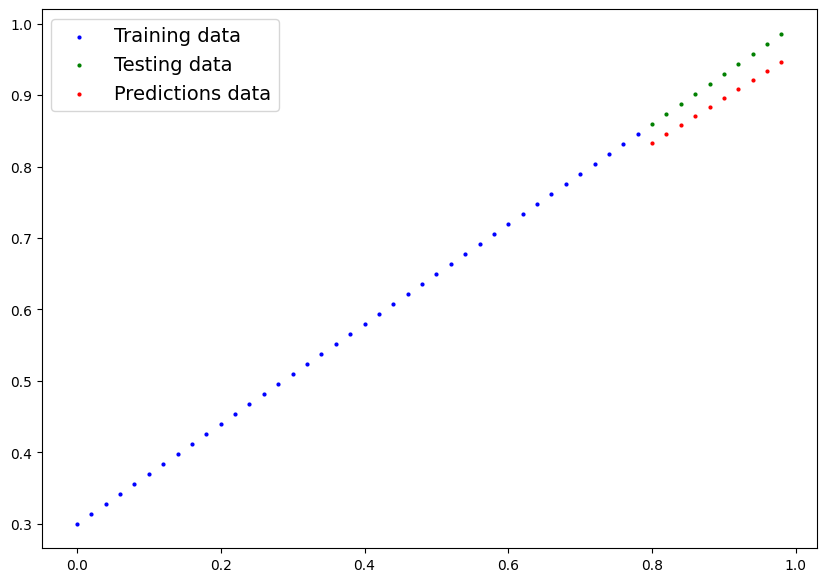

In [ ]:
plot_predictions(predictions=y_pred_new)

### Plotting the loss curves

In [ ]:
import numpy as np

np_training_loss_values = np.array(torch.tensor(training_loss_values).cpu().numpy())
np_test_loss_values = np.array(torch.tensor(test_loss_values).cpu().numpy())

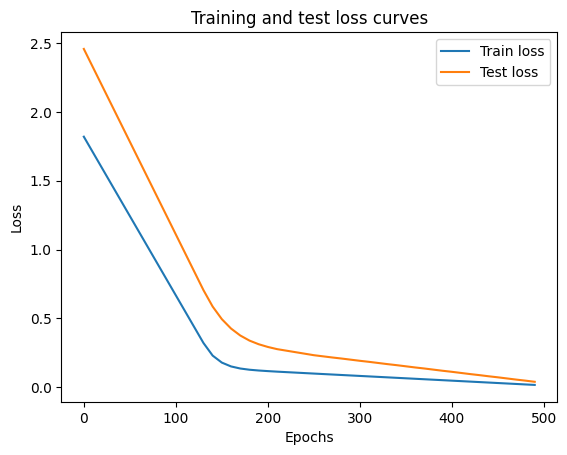

In [ ]:
plt.plot(epoch_count, np_training_loss_values, label="Train loss")
plt.plot(epoch_count, np_test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

### Saving a model

Methods to save a PyTorch object:
- `torch.save()` - save a PyTorch object in Python's pickle format
- `torch.load()` - allows you to load PyTorch object
- `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary

In [ ]:
# Saving our PyTorch model

from pathlib import Path

# 1. Create models directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "pytorch_workflow__model_01.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/pytorch_workflow__model_01.pth')

In [ ]:
# 3. Saving the model state dict

# print(f"Model saved to: {MODEL_SAVE_PATH}")
# torch.save(obj = model_0.state_dict(),
#           f=MODEL_SAVE_PATH)

Model saved to: models/pytorch_workflow__model_01.pth


In [ ]:
!ls models

pytorch_workflow__model_01.pth


### Load the saved model

In [ ]:
# To load in a saved state_dict, we need to instantiate a new instant of out model class
loaded_model_0 = LinearRegressionModel()

loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

<ipython-input-270-1b756775bd30>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


OrderedDict([('weights', tensor([0.6299])), ('bias', tensor([0.3293]))])

### Putting all back together(Practice)

In [1]:
# Imports
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.4.0+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


In [3]:
# Data creation

X = torch.arange(40, 91, 4).unsqueeze(dim = 1)
weights = 12.2
bias = 5.6

y = weights * X + bias
print(f"X: {X}")
print(f"y: {y}")

X: tensor([[40],
        [44],
        [48],
        [52],
        [56],
        [60],
        [64],
        [68],
        [72],
        [76],
        [80],
        [84],
        [88]])
y: tensor([[ 493.6000],
        [ 542.4000],
        [ 591.2000],
        [ 639.9999],
        [ 688.8000],
        [ 737.6000],
        [ 786.4000],
        [ 835.2000],
        [ 883.9999],
        [ 932.8000],
        [ 981.6000],
        [1030.3999],
        [1079.2000]])


In [4]:
# Train/Test split

split_ratio = 0.8 # 80:20 ratio
split = int(split_ratio * len(X))
X_train = X[:split]
X_test = X[split : ]

y_train = y[:split]
y_test = y[split : ]


X_train, X_test, y_train, y_test

(tensor([[40],
         [44],
         [48],
         [52],
         [56],
         [60],
         [64],
         [68],
         [72],
         [76]]),
 tensor([[80],
         [84],
         [88]]),
 tensor([[493.6000],
         [542.4000],
         [591.2000],
         [639.9999],
         [688.8000],
         [737.6000],
         [786.4000],
         [835.2000],
         [883.9999],
         [932.8000]]),
 tensor([[ 981.6000],
         [1030.3999],
         [1079.2000]]))

In [21]:
# plotting predictions


def plot_graph(X_train = X_train,
               y_train = y_train,
               X_test = X_test,
               y_test = y_test,
               predictions = None
               ) :
  import matplotlib.pyplot as plt


  plt.scatter(X_train, y_train, c="b")
  plt.scatter(X_test, y_test, c="g")

  if(predictions != None):
    plt.scatter(X_test, predictions, c="r")


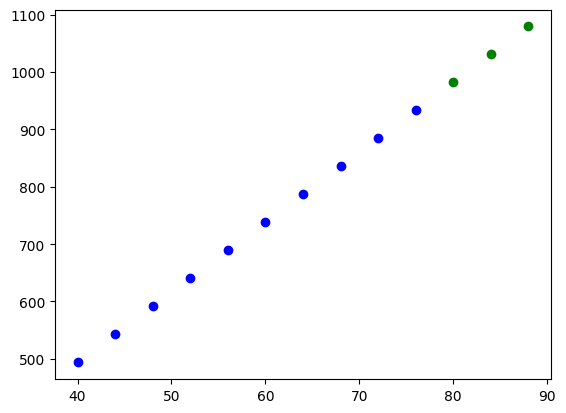

In [22]:
plot_graph()

In [37]:
## Building the model

from torch import nn

class LinRegModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                           dtype=torch.float32,
                                           requires_grad=True))

    self.bias = nn.Parameter(torch.randn(1,
                                           dtype=torch.float32,
                                           requires_grad=True))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return x * self.weights + self.bias

In [38]:
model_lin_reg = LinRegModel()
optimizer = torch.optim.SGD(model_lin_reg.parameters(), lr = 0.001)

loss_fn = nn.L1Loss()

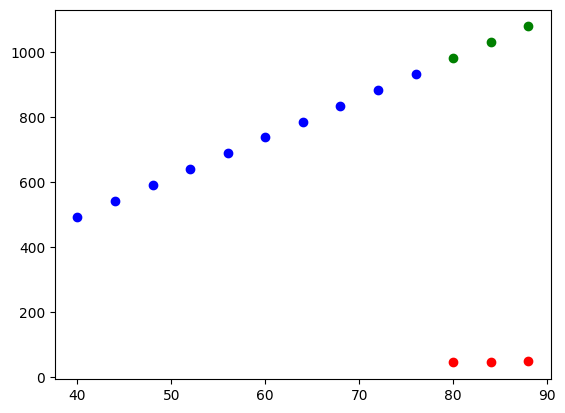

In [39]:
with torch.inference_mode():
  orig_preds = model_lin_reg(X_test)
  plot_graph(predictions=orig_preds)

In [41]:
epochs = 400

for epoch in range(epochs):
  model_lin_reg.train()

  model_pred = model_lin_reg(X_train)

  model_loss = loss_fn(model_pred, y_train)

  optimizer.zero_grad()

  model_loss.backward()

  optimizer.step()
  model_lin_reg.eval()
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss : {model_loss}")


Epoch: 0 | Loss : 344.72393798828125
Epoch: 10 | Loss : 311.0738525390625
Epoch: 20 | Loss : 277.4237976074219
Epoch: 30 | Loss : 243.77377319335938
Epoch: 40 | Loss : 210.1240234375
Epoch: 50 | Loss : 176.47421264648438
Epoch: 60 | Loss : 142.82449340820312
Epoch: 70 | Loss : 109.1747055053711
Epoch: 80 | Loss : 75.52494049072266
Epoch: 90 | Loss : 41.875152587890625
Epoch: 100 | Loss : 8.225369453430176
Epoch: 110 | Loss : 1.0231444835662842
Epoch: 120 | Loss : 1.0631500482559204
Epoch: 130 | Loss : 1.0311492681503296
Epoch: 140 | Loss : 1.014154076576233
Epoch: 150 | Loss : 1.018621802330017
Epoch: 160 | Loss : 1.0791046619415283
Epoch: 170 | Loss : 1.0571472644805908
Epoch: 180 | Loss : 1.023077368736267
Epoch: 190 | Loss : 1.014123558998108
Epoch: 200 | Loss : 1.0185973644256592
Epoch: 210 | Loss : 1.071038842201233
Epoch: 220 | Loss : 1.0657989978790283
Epoch: 230 | Loss : 1.0149993896484375
Epoch: 240 | Loss : 1.014105200767517
Epoch: 250 | Loss : 1.018579125404358
Epoch: 260 | 

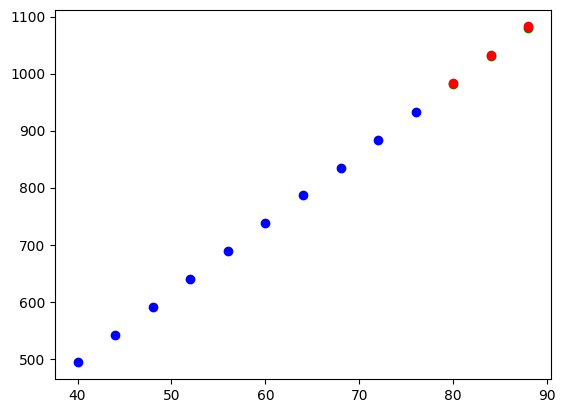

In [42]:
with torch.inference_mode():
  orig_preds = model_lin_reg(X_test)
  plot_graph(predictions=orig_preds)